In [1]:
import sys
import os
import numpy as np
import cv2
import Levenshtein
import difflib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import logging
from skimage.morphology import (erosion, dilation, closing, opening)

# preprocessing dataset
Function to preprocess image (convert to grayscale and apply binary thresholding)

In [2]:
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, binary_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    return img, binary_img

# Displaying the input images and binary images

In [3]:
def display_image(img, binary_img, title):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Original {title}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(binary_img, cmap='gray')
    plt.title(f"Binary {title}")
    plt.axis('off')

    plt.show()

# Function to find and draw contours

In [4]:
def segment_characters(binary_img, max_width=10, max_height=10):
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        if w > max_width and h > max_height:
            filtered_contours.append(contour)
            
    filtered_contours = sorted(filtered_contours, key=lambda ctr: cv2.boundingRect(ctr)[0])
    return filtered_contours

# Function to display contours

In [5]:
def display_contours(img, contours, title):
    img_with_contours = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(img_with_contours, (x, y), (x + w, y + h), (0, 255, 0), 2)

    plt.figure(figsize=(10, 5))
    plt.imshow(img_with_contours)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Samples of segmented charactests

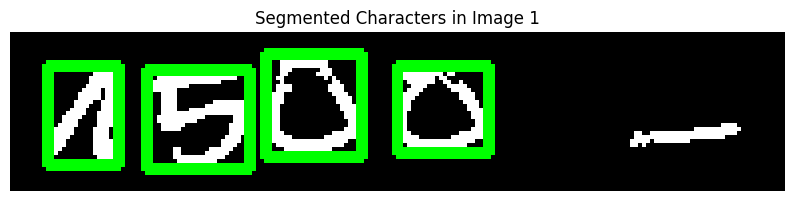

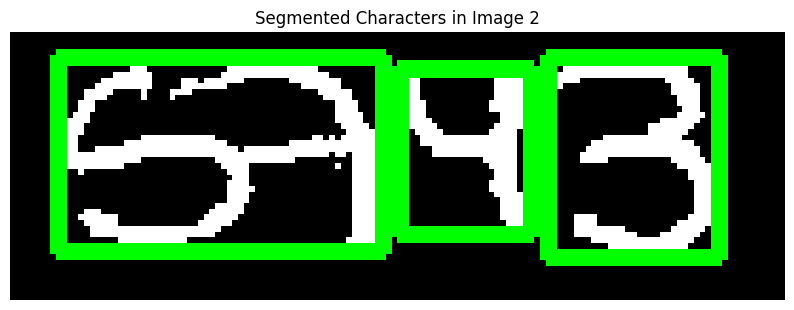

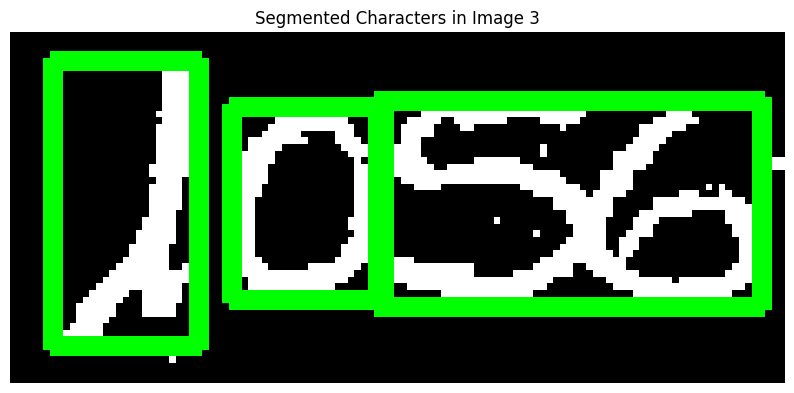

In [6]:
image_paths = ['./ORAND-CAR-2014/CAR-A/a_test_images/a_car_007000.png',
               "./ORAND-CAR-2014/CAR-A/a_test_images/a_car_007001.png",
               "./ORAND-CAR-2014/CAR-A/a_test_images/a_car_007002.png"]

# image_paths = ['./ORAND-CAR-2014/CAR-A/a_train_images/a_car_000155.png',
#                "./ORAND-CAR-2014/CAR-A/a_train_images/a_car_000156.png",
#                "./ORAND-CAR-2014/CAR-A/a_train_images/a_car_000157.png"]
for i, image_path in enumerate(image_paths):
    original, binary = preprocess_image(image_path)
    # display_image(original, binary, Image {i + 1})
    contours = segment_characters(binary)
    display_contours(binary, contours, f"Segmented Characters in Image {i + 1}")

